In this notebook I test the synthetic function (most difficult one) from the ART paper to see if the BO method can be tuned to beat it. While the ART paper is a bit sparse on detail to do this, since they do not share their source code (currently waiting for response), I will try to reverse engineer the method they used to tune the hyperparameters of the BO method.

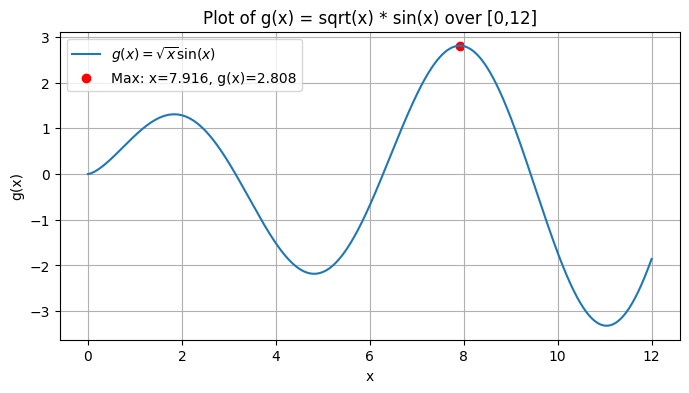

Maximum value of g(x) on [0,12]: 2.8081 at x = 7.9159


In [302]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define the function
def g(x):
    return torch.sqrt(x) * torch.sin(x)

# Create a fine grid from 0 to 12
x = torch.linspace(0, 12, 1000)
y = g(x)

# Convert to numpy for plotting
x_np = x.numpy()
y_np = y.numpy()

plt.figure(figsize=(8, 4))
plt.plot(x_np, y_np, label=r'$g(x) = \sqrt{x} \sin(x)$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.title('Plot of g(x) = sqrt(x) * sin(x) over [0,12]')
plt.grid(True)

# Find the maximum value and location
max_idx = torch.argmax(y)
max_x = x[max_idx].item()
max_y = y[max_idx].item()

# Mark the maximum on the plot
plt.scatter([max_x], [max_y], color='red', label=f'Max: x={max_x:.3f}, g(x)={max_y:.3f}')
plt.legend()
plt.show()

print(f"Maximum value of g(x) on [0,12]: {max_y:.4f} at x = {max_x:.4f}")


In [303]:
import numpy as np
import torch
from pyDOE3 import lhs

from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qUpperConfidenceBound
from botorch.acquisition.logei import qLogNoisyExpectedImprovement
from botorch.optim import optimize_acqf

from gpytorch import kernels, means, likelihoods
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from gpytorch.priors import SmoothedBoxPrior, GammaPrior

In [304]:
seed = 42 #this keeps the lhs consistent
initial_sample = 16
nu=2.5
batch_size = initial_sample

iterations = 100

lengthscale_prior = GammaPrior(2.0, 4.0) # mean around 0.5, variance around 0.35
# beta = 2 */ torch.log(torch.tensor(t+1.0)).sqrt() # apparently theoretically grounded in Srinivas et al 2010

#since these are noiseless I adjust the model here from og 
fixed_noise = True   # turn this to False for learning noise; True for noiseless (still creates small nosie)

noise_level = 1e-2 # keep a super small noise to check the model can learn noise while testing
# noise boudarys for the likelihood (Gaussian) model in standard deviations. 
# even though this test is noiseless, we keep these here to test the noise learning gp model
lower_noise_bound = 1e-4**2
upper_noise_bound = 1e-2**2

In [305]:
dimensions = 7

bounds = torch.tensor([
    [0.0]* dimensions,  # Lower bounds
    [12.0]* dimensions   # Upper bounds 
], dtype=torch.double)


for i in range(dimensions):
    np.sqrt(i)*np.sin(i)

print(bounds.shape)


torch.Size([2, 7])


In [306]:

# standard Latin hypercube using maximin criterion (converts to tensor) (all values between 0 and 1)
lhs_design = torch.tensor(
            lhs(n = dimensions, samples = initial_sample, criterion = 'maximin', random_state=seed), 
        dtype=torch.double
        )

# scales the lhs over arbitrary dimensions to the preset bounds for input into objective function
scaled_lhs_design = bounds[0] + (bounds[1]-bounds[0])*lhs_design


In [307]:
scaled_lhs_design.shape
print(scaled_lhs_design)

tensor([[ 2.1124,  6.5205,  5.1576,  8.7050,  2.9299, 10.0014,  2.3377],
        [ 6.4809,  1.3609,  2.5379,  3.1045,  9.6292, 10.7598,  9.6906],
        [10.4024,  2.9247,  6.4070,  9.7386,  6.8650,  8.0225,  6.6813],
        [ 7.1875,  7.0506,  3.2512, 10.9030,  3.5955,  2.7182,  3.7751],
        [ 2.4242,  1.8294,  8.6822,  8.1991,  3.9364,  7.1897,  5.7900],
        [ 4.9274, 10.7501,  7.0965,  6.1888,  1.7260,  4.5830,  1.8770],
        [ 8.7804,  3.4708,  8.1541,  1.1423,  7.9238, 11.3823, 11.6238],
        [10.5035, 10.1391,  3.8638, 11.5893,  6.2593,  8.8023,  8.1919],
        [ 0.8732,  7.5136, 10.7986,  7.4605, 11.3556,  1.4079,  0.1227],
        [11.8031,  5.0718,  1.2489,  4.7566,  5.4219,  5.7917,  8.9508],
        [ 7.9586,  0.4309,  1.7827,  5.3624,  9.7911,  0.1512,  7.1294],
        [ 9.6942,  5.5480,  5.8480,  0.1048,  1.0191,  9.0935, 10.7602],
        [ 0.5558,  9.3381,  0.6314,  2.6577,  8.5681,  2.0607,  1.0443],
        [ 5.3456,  8.3644,  9.0849,  1.8470, 11.189

In [308]:
def objective_function(X):
    """
    X: Tensore of shape (n_samples, dim)
    Returns: Tensor of shape (n_samples, 1)
    """

    y = torch.sqrt(X) * torch.sin(X) # shape (n_samples, dim)
    y_sum= y.sum(dim=1)

    return y_sum.unsqueeze(-1)

In [309]:
train_X = scaled_lhs_design
train_Y = objective_function(train_X)

print(train_Y)
train_Y.shape

tensor([[  1.4773],
        [ -2.0264],
        [  2.2773],
        [ -0.8385],
        [  6.5742],
        [ -3.1665],
        [  1.8027],
        [ -4.6931],
        [  0.6600],
        [ -7.1384],
        [  3.4789],
        [ -4.7435],
        [  6.2475],
        [ -2.9687],
        [-12.5755],
        [-10.8360]], dtype=torch.float64)


torch.Size([16, 1])

In [310]:
# Gaussian Process Model

# Only for further GP Model development

# Setup (Assume train_X, train_Y, bounds, and objective_function are defined)
# ===========================



# GP Model definition
class GPModel(SingleTaskGP):
    def __init__(self, train_X, train_Y, fixed_noise, noise_level=noise_level,
                 lengthscale_prior=None, outputscale_prior=None,
                 lengthscale_constraint = None, outputscale_constraint=None):

        if fixed_noise:
            print(f"Training with FIXED noise: {noise_level} = std dev.")
            noise_variance = (noise_level * train_Y.mean()).pow(2)
            train_Yvar = torch.full_like(train_Y, noise_variance)
            likelihood = None
            super().__init__(
                train_X, train_Y, train_Yvar=train_Yvar, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dimensions)
            )
        else:
            print("Training with LEARNABLE noise (Gaussian Likelihood).")
            likelihood = likelihoods.GaussianLikelihood()
            super().__init__(
                train_X, train_Y, likelihood=likelihood,
                outcome_transform=Standardize(m=1),
                input_transform=Normalize(d=dimensions)
            )
            lower_noise = lower_noise_bound**2  # lower noise bound
            upper_noise = upper_noise_bound**2  # upper noise bound

            # Add a **prior** (softly nudges during training)
            
            self.likelihood.noise_covar.register_prior(
                "noise_prior",
                SmoothedBoxPrior(lower_noise, upper_noise),
                "raw_noise"
            )
            
            # Add a **constraint** (hard bounding box)
            self.likelihood.noise_covar.register_constraint(
                "raw_noise",
                Interval(lower_noise, upper_noise)
            )
            

        self.mean_module = means.ConstantMean()#ZeroMean() # this is default ConstantMean() in GPyTorch. Worth investigating

        matern_kernel = kernels.MaternKernel(
            nu=nu,
            ard_num_dims=dimensions,
            lengthscale_prior=lengthscale_prior,
            lengthscale_constraint=lengthscale_constraint,
        )

        self.covar_module = kernels.ScaleKernel(
            base_kernel=matern_kernel,
            outputscale_prior=outputscale_prior,
            outputscale_constraint=outputscale_constraint,
        )
        
        
        
# the above is preset, and doesn't require much changing unless adding other features

# the below is the training function, whatever input into this will feed through the model above 
# (I.e., set lengthscale_prior here, and it will filter in above)
        
# Training function
def train_GP_model(train_X, train_Y, fixed_noise, noise_level=noise_level,
                   lengthscale_prior=lengthscale_prior, outputscale_prior=None,
                   lengthscale_constraint = None, outputscale_constraint=None): 
    model = GPModel(
        train_X, train_Y,
        fixed_noise=fixed_noise,
        noise_level=noise_level,
        lengthscale_prior=lengthscale_prior,
        outputscale_prior=outputscale_prior,
        lengthscale_constraint = lengthscale_constraint, 
        outputscale_constraint=outputscale_constraint
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    #===== Fit the model =====#
    fit_gpytorch_mll(mll) # This is the default (turn off the custom training loop below if using this)

    # to use a custom optimizer and make this model fully customizable you can use the bit below 
    # make sure to turn off the fit_gpytorch_mll above
    '''
    # Custom training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    model.train()
    mll.train()
    training_iter = 50
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, train_Y.squeeze(-1))
        loss.backward()
        optimizer.step()
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")
    #===== End of custom training loop =====#
    '''
    return model, mll


In [311]:
# BO Loop
# ===========================
# The learning stacks, so you can repeat this loop to get better results.


normalized_bounds = torch.stack([torch.zeros(bounds.shape[1], dtype=bounds.dtype), 
                                 torch.ones(bounds.shape[1], dtype=bounds.dtype)
                                ])
n_iterations = iterations # of BO LOOP 



num_restarts = 20 # restarts loop if it can't converge answer (also can improve answer by finding a better local optima)
raw_samples = 40 # total resamples taken for analysis
batch_size = batch_size # this is q THE REALWORLD # of EXPENSIVE EXPERIMENTS that your willing to do per BATCH

best_Ys = []

for iteration in range(n_iterations):
    print(f"\n=== Iteration {iteration + 1} ===")
    # Train model
    model, mll = train_GP_model(train_X, train_Y, 
                                #lengthscale_prior=lengthscale_prior, outputscale_prior=outputscale_prior, 
                                #lengthscale_constraint=lengthscale_constraint, outputscale_constraint=outputscale_constraint, 
                                fixed_noise)
    '''
    # Recompute batch_initial_conditions each iteration (important!)
    topk = torch.topk(train_Y.squeeze(), k=num_restarts, largest=True)
    batch_initial_conditions = X_normalized[topk.indices].unsqueeze(1)
    #best_f = model.outcome_transform(train_Y)[0].max().item() # best observed value so far (for EI)
    '''

    model.eval() #apparently this is good practice... though the model seemed to work fine without this
    model.likelihood.eval()
    # Acquisition function (try switching between UCB and qLogNEI to compare)
    
    
    #acq_func = qLogNoisyExpectedImprovement(model=model, X_baseline=train_X)
    beta = 2 / torch.log(torch.tensor(iteration+2.0)).sqrt()
    acq_func = qUpperConfidenceBound(model=model, beta=beta) # this is the UCB acquisition function

    # Optimize acquisition function
    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=batch_size,
        num_restarts=num_restarts,
        raw_samples=raw_samples,
    )

    # Evaluate objective
    new_y = objective_function(candidate)
    train_X = torch.cat([train_X, candidate], dim=0)


    train_Y = torch.cat([train_Y, new_y], dim=0)
    
    # some diagnostics
    print(train_Y.shape)
    best_idx = torch.argmax(train_Y.squeeze(-1))
    best_X = train_X[best_idx]
    best_Y = train_Y[best_idx].item()
    print(f"Best Y: {best_Y:.4f} at X: {best_X}")
    best_Ys.append(best_Y)

    print("Max predicted mean:", model.posterior(train_X).mean.max().item())



=== Iteration 1 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([32, 1])
Best Y: 8.0130 at X: tensor([1.1901, 0.0904, 7.8645, 7.3389, 5.0188, 6.7415, 7.9996],
       dtype=torch.float64)
Max predicted mean: 6.574099414648403

=== Iteration 2 ===
Training with FIXED noise: 0.01 = std dev.


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


torch.Size([48, 1])
Best Y: 11.8063 at X: tensor([0.0000, 0.0000, 7.2315, 8.0757, 1.8230, 7.6961, 7.9815],
       dtype=torch.float64)
Max predicted mean: 8.01302849472716

=== Iteration 3 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([64, 1])
Best Y: 11.8063 at X: tensor([0.0000, 0.0000, 7.2315, 8.0757, 1.8230, 7.6961, 7.9815],
       dtype=torch.float64)
Max predicted mean: 11.806081455381232

=== Iteration 4 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([80, 1])
Best Y: 13.3931 at X: tensor([0.0000, 1.2231, 7.8102, 7.8625, 1.8328, 7.6635, 7.6833],
       dtype=torch.float64)
Max predicted mean: 12.035233620742758

=== Iteration 5 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([96, 1])
Best Y: 16.5473 at X: tensor([8.2610, 0.4692, 8.2237, 7.9976, 8.2876, 7.7730, 7.6872],
       dtype=torch.float64)
Max predicted mean: 13.392032197432897

=== Iteration 6 ===
Training with FIXED noise: 0.01 = std dev.
torch.Size([112, 1])
Best Y: 16.6833 at X: tensor(

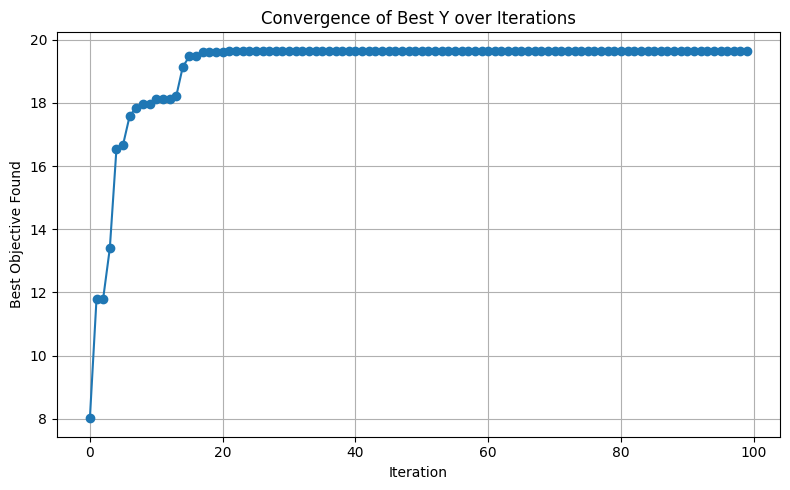

In [312]:
plt.figure(figsize=(8, 5))
plt.plot(best_Ys, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Objective Found")
plt.title("Convergence of Best Y over Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()

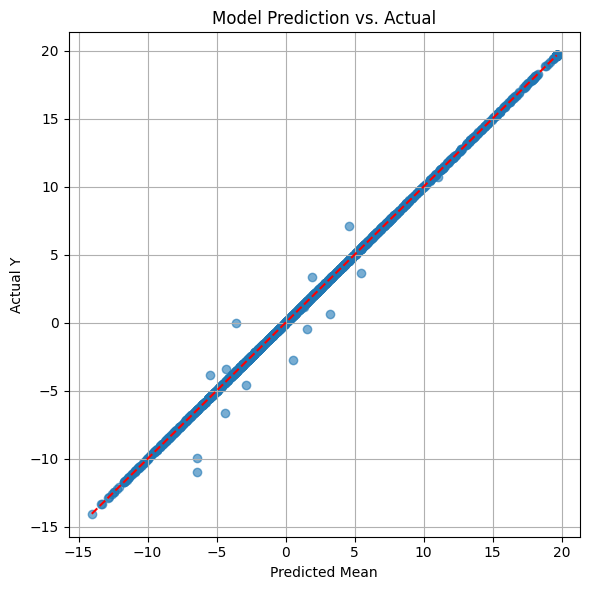

In [313]:
with torch.no_grad():
    posterior_mean = model.posterior(train_X).mean.squeeze(-1)

plt.figure(figsize=(6, 6))
plt.scatter(posterior_mean, train_Y.squeeze(-1), alpha=0.6)
plt.plot([train_Y.min(), train_Y.max()], [train_Y.min(), train_Y.max()], 'r--')
plt.xlabel("Predicted Mean")
plt.ylabel("Actual Y")
plt.title("Model Prediction vs. Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

In [314]:
# observed best
print(f"Best Y: {best_Y:.4f} at X: {best_X}")


# best model prediction
print("Max predicted mean:", model.posterior(train_X).mean.max().item())

print(f"Outputscale: {model.covar_module.outputscale.item():.6f}")
    
    
print(f"Lengthscale : {model.covar_module.base_kernel.lengthscale}")

Best Y: 19.6556 at X: tensor([7.9129, 7.9291, 7.9095, 7.9072, 7.9097, 7.8938, 7.9175],
       dtype=torch.float64)
Max predicted mean: 19.655630720446794
Outputscale: 0.479303
Lengthscale : tensor([[0.3306, 0.3409, 0.3206, 0.3349, 0.3083, 0.2936, 0.4067]],
       grad_fn=<SoftplusBackward0>)


In [315]:
# this is the very approximate best answer 5pi/2 = 7.854, but actual best answers shoule be around 7.915

X = torch.full((1, dimensions), 5*np.pi/2, dtype=torch.double)

y = objective_function(X)

print(f"Objective function value at {X}: {y.item()}")


Objective function value at tensor([[7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540, 7.8540]],
       dtype=torch.float64): 19.61746925739275
